# **Notebook: Double Descent**

Nombre:

Numero de estudiante:

---

Esta notebook investiga el fenómeno **double descent** que ocurre en las Redes Neuronales.

En el aprendizaje automático, a menudo esperamos que a medida que la capacidad de un modelo (por ejemplo, el número de parámetros) aumenta, el error de entrenamiento disminuya y el error de prueba eventualmente aumente después de cierto punto (el clásico "overfitting"). Sin embargo, el fenómeno de Double Descent desafía esta intuición al mostrar que, en ciertos escenarios, a medida que la capacidad del modelo continúa aumentando más allá del punto de overfitting, el error de prueba puede volver a disminuir.

En esta notebook:

- Utilizamos el dataset MNIST-1D que se puede encontrar en https://github.com/greydanus/mnist1d.
- Entrenamos redes con diferentes capacidades (variando el número de unidades ocultas)
- Analizamos cómo el ruido en las etiquetas del conjunto de entrenamiento influye en la forma de la curva Double Descent.

## Dataset

In [16]:
# Instalar el dataset MNIST 1D
!pip install git+https://github.com/greydanus/mnist1d

  Cloning https://github.com/greydanus/mnist1d to /private/var/folders/s2/p5yczv2s3gv32c5qs90gpnh00000gn/T/pip-req-build-uruufyte
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d /private/var/folders/s2/p5yczv2s3gv32c5qs90gpnh00000gn/T/pip-req-build-uruufyte
  Resolved https://github.com/greydanus/mnist1d to commit 7878d96082abd200c546a07a4101fa90b30fdf7e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [17]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import mnist1d
from torchinfo import summary
import torch.optim as optim

from sklearn.model_selection import train_test_split

import random
random.seed(0)

from utils import (
    train,
    evaluate,
    model_classification_report,
    show_tensor_image,
    show_tensor_images,
    plot_training,
    EarlyStopping,
    print_log,
    plot_sweep_metrics_comparison,
    download_run,
    plot_class_distribution
)


In [18]:
# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS
elif torch.xpu.is_available():
    DEVICE = "xpu"  # si no hay GPU, pero hay XPU, usamos XPU

print(f"Usando {DEVICE}")

Usando mps


In [19]:
def get_noisy_mnist1d_dataset(noise_rate=0.0):
    """
    Generates the MNIST-1D dataset with a specified amount of noise in the training labels.

    Args:
        noise_rate (float): The proportion of training labels to flip randomly.

    Returns:
        dict: A dictionary containing the noisy dataset.
    """
    args = mnist1d.data.get_dataset_args()
    args.num_samples = 8000
    args.train_split = 0.5
    args.corr_noise_scale = 0.25
    args.iid_noise_scale = 2e-2
    data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl',
                                    download=False, regenerate=True)

    # Add noise to training labels
    for c_y in range(len(data['y'])):
        random_number = random.random()
        if random_number < noise_rate:
            random_int = int(random.random() * 10)
            data['y'][c_y] = random_int

    return data

In [20]:
data = get_noisy_mnist1d_dataset(noise_rate=0.0)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Dimensionality of each example: {}".format(data['x'].shape[-1]))

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Examples in training set: 4000
Examples in test set: 4000
Dimensionality of each example: 40


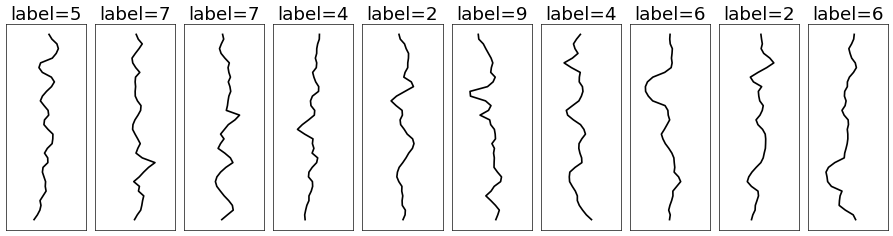

In [21]:
def plot_signals(xs, t, labels=None, ratio=2.6, zoom=1):
    rows, cols = 1, 10
    fig = plt.figure(figsize=[cols*1.5,rows*1.5*ratio], dpi=60)
    for r in range(rows):
        for c in range(cols):
            ix = r*cols + c
            x, t = xs[ix], t
            ax = plt.subplot(rows,cols,ix+1)

            # plot the data
            plt.plot(x, t, 'k-', linewidth=2)
            if labels is not None:
                plt.title("label=" + str(labels[ix]), fontsize=22)

            plt.xlim(-zoom,zoom) ; plt.ylim(-zoom,zoom)
            plt.gca().invert_yaxis() ; plt.xticks([], []), plt.yticks([], [])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout() ; plt.show()
    return fig


# Sample 10 random examples from test
num_test_examples = len(data['y_test'])
sample_indices_test = random.sample(range(num_test_examples), 10)

xs = data['x_test'][sample_indices_test]
labels = data['y_test'][sample_indices_test]
t = data['t']
_ = plot_signals(xs, t, labels=labels, ratio=2.7, zoom=6)

Ahora definiremos la función `get_model`, encargada de construir nuestra red neuronal.

**Tarea:**
Completa la función `get_model` con las siguientes especificaciones:

1. Define las dimensiones:
    * Entrada (D_i): debe coincidir con la dimensionalidad de cada muestra del dataset MNIST-1D.
    * Oculta (n_hidden): se recibe como argumento de la función.
    * Salida (D_o): igual al número de clases.

2. Crea una arquitectura secuencial con las siguientes capas:
    - Capa lineal de entrada.
    - Activación ReLU.
    - Capa lineal oculta.
    - Activación ReLU.
    - Capa lineal de salida.

3. Devuelve el modelo resultante.

In [22]:
print(data['x'].shape) #(N, D)
print(f"Número de ejemplos de entrenamiento: {data['x'].shape[0]}")
print(f"Dimensionalidad de cada ejemplo: {data['x'].shape[-1]}")
INPUT_DIM = data['x'].shape[-1]
OUTPUT_DIM = len(np.unique(data['y']))
print(f"Número de clases: {OUTPUT_DIM}")

(4000, 40)
Número de ejemplos de entrenamiento: 4000
Dimensionalidad de cada ejemplo: 40
Número de clases: 10


In [ ]:
def get_model(n_hidden):

  D_i = INPUT_DIM    # Input dimensions
  D_k = n_hidden   # Hidden dimensions
  D_o = OUTPUT_DIM    # Output dimensions

  # Completar
  model = nn.Sequential(
    nn.Linear(D_i, D_k), # capa lineal de entrada
    nn.ReLU(), # activación ReLU
    nn.Linear(D_k, D_k), # capa lineal oculta
    nn.ReLU(), # activación ReLU
    nn.Linear(D_k, D_o) # capa lineal de salida
  )

  # Return the model
  return model;

In [24]:
model = get_model(n_hidden=64)  # por ejemplo
summary(model, input_size=(INPUT_DIM,))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [10]                      --
├─Linear: 1-1                            [64]                      2,624
├─ReLU: 1-2                              [64]                      --
├─Linear: 1-3                            [64]                      4,160
├─ReLU: 1-4                              [64]                      --
├─Linear: 1-5                            [10]                      650
Total params: 7,434
Trainable params: 7,434
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.44
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03

## Entrenamiento y visualización de la curva *Double Descent*

En esta sección vamos a explorar cómo varían el **error de entrenamiento** y el **error de prueba** al aumentar la capacidad de una red neuronal.

**Tu tarea:**

1. Entrena redes neuronales con distintos números de unidades ocultas (`n_hidden`) durante **1000 épocas**, usando los siguientes tamaños de capa oculta:  
   `[2, 10, 26, 45, 48, 50, 55, 70, 120, 200, 250]`.  
2. Registra los errores finales de entrenamiento y prueba para cada modelo.  
3. Grafica los errores en función del número de unidades ocultas para visualizar la **curva de Double Descent**.  
4. Añade una línea vertical que marque el **interpolation threshold**, que se puede representar como el punto en que el número de parámetros del modelo se aproxima al número de ejemplos de entrenamiento. El pico del error de prueba suele aparecer cerca de esta región.

> 💡 **Nota:** la ejecución del código puede tomar un tiempo considerable, ¡así que quizás sea un buen momento para tomar un descanso!


In [64]:
LR = 0.01
CRITERION = nn.CrossEntropyLoss().to(DEVICE)
BATCH_SIZE = 512
EPOCHS = 1000
HIDDEN_SIZES = [2, 10, 26, 45, 48, 50, 55, 70, 120, 200, 250, 300]

In [65]:
# Dividimos train/val
X_train, X_val, y_train, y_val = train_test_split(
    data['x'], data['y'], test_size=0.2, random_state=42
)

# Convertimos a tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Creamos datasets y dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [66]:
def train_model(n_hidden):
    base_model = get_model(n_hidden).to(DEVICE)

    optimizer = optim.Adam(base_model.parameters(), lr=LR)
    

    epoch_train_errors, epoch_val_errors = train(
        base_model,
        optimizer,
        CRITERION,
        train_loader,
        val_loader,
        DEVICE,
        do_early_stopping=True,
        patience=50,
        epochs=EPOCHS,
        log_every=100,
    )

    return epoch_train_errors[-1], epoch_val_errors[-1]

In [67]:
training_errors = []
validation_errors = []
for n_hidden in HIDDEN_SIZES:
    print(f"\nEntrenando modelo con {n_hidden} unidades ocultas")
    train_error, val_error = train_model(n_hidden)
    training_errors.append(train_error)
    validation_errors.append(val_error)



Entrenando modelo con 2 unidades ocultas
Epoch: 100/1000 | Train Loss: 1.72122 | Val Loss: 1.72918
Epoch: 200/1000 | Train Loss: 1.66788 | Val Loss: 1.67738
Epoch: 300/1000 | Train Loss: 1.63265 | Val Loss: 1.64349
Epoch: 400/1000 | Train Loss: 1.62637 | Val Loss: 1.63565
Epoch: 500/1000 | Train Loss: 1.62110 | Val Loss: 1.63777
Detener entrenamiento en la época 527, la mejor pérdida fue 1.62826

Entrenando modelo con 10 unidades ocultas
Epoch: 100/1000 | Train Loss: 1.28287 | Val Loss: 1.35068
Detener entrenamiento en la época 116, la mejor pérdida fue 1.32124

Entrenando modelo con 26 unidades ocultas
Epoch: 100/1000 | Train Loss: 0.66467 | Val Loss: 1.43646
Detener entrenamiento en la época 101, la mejor pérdida fue 1.25989

Entrenando modelo con 45 unidades ocultas
Detener entrenamiento en la época 77, la mejor pérdida fue 1.24672

Entrenando modelo con 48 unidades ocultas
Detener entrenamiento en la época 69, la mejor pérdida fue 1.17151

Entrenando modelo con 50 unidades ocultas

In [68]:
print(f"Entrenamiento finalizado. Errores finales:")
print(f"Entrenamiento: {training_errors}")
print(f"Validación: {validation_errors}")


Entrenamiento finalizado. Errores finales:
Entrenamiento: [1.6253028426851546, 1.2412187201636178, 0.6539101430347988, 0.2955797548804964, 0.26190246428762165, 0.217552444764546, 0.12537236937454768, 0.06363998140607562, 0.004440204173858676, 0.0021464952400752474, 0.0007759454061410256, 0.000922127892928464]
Validación: [1.6330302357673645, 1.3490530848503113, 1.4619665145874023, 1.9015158414840698, 1.8219048380851746, 2.0872864723205566, 2.1635899543762207, 2.3453034162521362, 2.2574622631073, 2.101015329360962, 2.0732589960098267, 2.055599808692932]


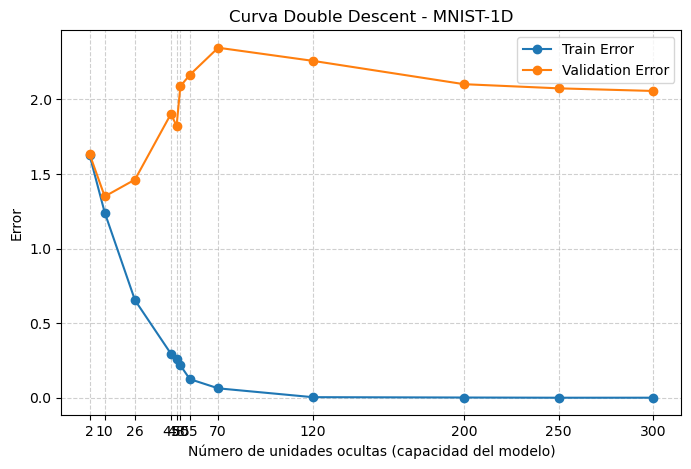

In [69]:
plt.figure(figsize=(8,5))
plt.plot(HIDDEN_SIZES, training_errors, 'o-', label='Train Error')
plt.plot(HIDDEN_SIZES, validation_errors, 'o-', label='Validation Error')

# Eje X con etiquetas exactas de las capas ocultas
plt.xticks(HIDDEN_SIZES)

plt.xlabel('Número de unidades ocultas (capacidad del modelo)')
plt.ylabel('Error')
plt.title('Curva Double Descent - MNIST-1D')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


## Explorando el *Double Descent* con etiquetas ruidosas

En esta sección repetiremos el experimento anterior, pero introduciendo **ruido en las etiquetas** del conjunto de entrenamiento para analizar cómo afecta al fenómeno *Double Descent*.

Entrenaremos nuevamente el modelo con los mismos tamaños de capa oculta:  
`[2, 10, 26, 45, 48, 50, 55, 70, 120, 200, 250]`,  
pero esta vez usaremos datasets en los que un porcentaje de las etiquetas ha sido aleatorizado. Realizaremos el experimento con dos niveles de ruido: **10 %** y **30 %**.

Después de entrenar los modelos para cada nivel de ruido, graficaremos las curvas de error de entrenamiento y prueba, similar a como lo hicimos anteriormente.

**Tu tarea:**

1. Ejecuta la celda siguiente para cargar los datasets con **10 %** y **30 %** de ruido.  
2. Adapta el código de entrenamiento y visualización de la sección anterior para entrenar los modelos con los conjuntos ruidosos y graficar los resultados.


In [59]:
# Carga el dataset MNIST-1D con 10% de ruido en las etiquetas de entrenamiento
data_noisy_10 = get_noisy_mnist1d_dataset(noise_rate=0.10)

# Puedes imprimir información sobre el dataset ruidoso para verificarlo
print("Dataset con 10% de ruido:")
print("Ejemplos en entrenamiento:", len(data_noisy_10['y']))
print("Ejemplos en prueba:", len(data_noisy_10['y_test']))
print("-" * 20)

# Repite el proceso para el 30% de ruido (modificando la tasa de ruido)
data_noisy_30 = get_noisy_mnist1d_dataset(noise_rate=0.30)

print("Dataset con 30% de ruido:")
print("Ejemplos en entrenamiento:", len(data_noisy_30['y']))
print("Ejemplos en prueba:", len(data_noisy_30['y_test']))

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Dataset con 10% de ruido:
Ejemplos en entrenamiento: 4000
Ejemplos en prueba: 4000
--------------------
Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Dataset con 30% de ruido:
Ejemplos en entrenamiento: 4000
Ejemplos en prueba: 4000


## Preguntas finales

1. ¿Cómo afecta el **ruido en las etiquetas** al error mínimo de entrenamiento alcanzable? ¿Por qué ocurre esto?  
2. Según tus observaciones, ¿cómo influye el **ruido en las etiquetas** en el fenómeno de *Double Descent*, especialmente en relación con la **capacidad del modelo** y su **capacidad de generalización**?  
3. En *Deep Learning*, ¿es lo mismo el **overfitting** durante el entrenamiento que la **sobreparametrización** de los modelos? Explica las diferencias.
